*Copyright (c) Microsoft Corporation. All rights reserved.*

*Licensed under the MIT License.*

# Text Classification of MultiNLI Sentences using XLNet
**XLNet: Generalized Autoregressive Pretraining for Language Understanding** [\[1\]](#References)

## What is XLNet?

[XLNet](https://arxiv.org/pdf/1906.08237.pdf) is a generalized autoregressive pretraining method incorporating 3 ideas:
1. maximum expected likelihood over all permutations of the factorization order that enables learning bidirectional context
2. autoregressive formulation that overcomes the limitations of BERT [\[2\]](#References)
3. relative positional embeddings and recurrence mechanism from Transformer XL [\[3\]](#References)

## How to use XLNet for Text Classification on MNLI dataset?

Using a pre-trained XLNet model, we can fine-tune the model for text classification by training it on the MNLI dataset [\[4\]](#References). The Multi-Genre Natural Language Inference (MultiNLI) corpus is a crowd-sourced collection of 433k sentence pairs annotated with textual entailment information. 

This notebook contains an end-to-end walkthrough of a pipeline to run Hugging Face's reimplementation [\[5\]](#References) of the XLNet model.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../")
import os
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from utils_nlp.dataset.multinli import load_pandas_df
from utils_nlp.eval.classification import eval_classification
from utils_nlp.common.timer import Timer
from utils_nlp.models.xlnet.common import Language, Tokenizer
from utils_nlp.models.xlnet.sequence_classification import XLNetSequenceClassifier
from utils_nlp.models.xlnet.utils import generate_confusion_matrix

## Introduction
In this notebook, we fine-tune and evaluate a pretrained [XLNet](https://arxiv.org/abs/1906.08237) model on a subset of the [MultiNLI](https://www.nyu.edu/projects/bowman/multinli/) dataset.

We use a [sequence classifier](../../utils_nlp/xlnet/sequence_classification.py) that wraps [Hugging Face's PyTorch implementation](https://github.com/huggingface/pytorch-transformers) of CMU and Google's [XLNet](https://github.com/zihangdai/xlnet).

In [3]:
DATA_FOLDER = "../../../temp"
XLNET_CACHE_DIR="../../../temp"
LANGUAGE = Language.ENGLISHCASED
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 8
NUM_GPUS = 1
NUM_EPOCHS = 3
TRAIN_SIZE = 0.6
LABEL_COL = "genre"
TEXT_COL = "sentence1"
WEIGHT_DECAY = 0.0
WARMUP_STEPS = 0

### Hyperparamters to tune
MAX_SEQ_LENGTH = 128
LEARNING_RATE = 5e-5
ADAM_EPSILON = 1e-8

DEBUG = True

## Read Dataset
We start by loading a subset of the data. The following function also downloads and extracts the files, if they don't exist in the data folder.

The MultiNLI dataset is mainly used for natural language inference (NLI) tasks, where the inputs are sentence pairs and the labels are entailment indicators. The sentence pairs are also classified into *genres* that allow for more coverage and better evaluation of NLI models.

For our classification task, we use the first sentence only as the text input, and the corresponding genre as the label. We select the examples corresponding to one of the entailment labels (*neutral* in this case) to avoid duplicate rows, as the sentences are not unique, whereas the sentence pairs are.

In [4]:
df = load_pandas_df(DATA_FOLDER, "train")
df = df[df["gold_label"]=="neutral"]  # get unique sentences

if DEBUG:
    inds = random.sample(range(len(df.index)), 1000)
    df = df.iloc[inds]

In [5]:
df.head()

,annotator_labels,genre,gold_label,pairID,promptID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
182772,[neutral],telephone,neutral,40246n,40246,yeah that'll be nice i mean that that i think ...,( ( yeah ( that ( 'll ( be ( nice ( i ( mean (...,(ROOT (S (NP (NP (NN yeah)) (SBAR (WHNP (WDT t...,I think that stadiums want to keep people happ...,( I ( ( think ( that ( stadiums ( want ( to ( ...,(ROOT (S (NP (PRP I)) (VP (VBP think) (SBAR (I...
130714,[neutral],government,neutral,24578n,24578,In providing services and in establishing clas...,( ( In ( ( ( ( providing services ) and ) in )...,(ROOT (S (PP (IN In) (S (VP (VP (VBG providing...,Job termination will be met to any Postal Serv...,( ( Job termination ) ( ( will ( be ( met ( to...,(ROOT (S (NP (NNP Job) (NN termination)) (VP (...
309892,[neutral],travel,neutral,117062n,117062,"First stop, off a side road to Fusina, is Pall...","( ( ( ( ( ( First stop ) , ) ( off ( a side ) ...","(ROOT (S (NP (NP (JJ First) (NN stop)) (, ,) (...",The Venetian countess stayed at the canal for ...,( ( The ( Venetian countess ) ) ( ( ( stayed (...,(ROOT (S (NP (DT The) (NNP Venetian) (NNS coun...
306417,[neutral],telephone,neutral,142240n,142240,you put five Soviet Hyundee helicopters in the...,( you ( ( put ( five ( Soviet ( Hyundee helico...,(ROOT (S (NP (PRP you)) (VP (VBD put) (NP (CD ...,The helicopters flew at 5000 feet.,( ( The helicopters ) ( ( flew ( at ( 5000 fee...,(ROOT (S (NP (DT The) (NNS helicopters)) (VP (...
220148,[neutral],travel,neutral,42939n,42939,"Inside the cathedral, the Capilla de los Velez...","( ( Inside ( the cathedral ) ) ( , ( ( ( the (...",(ROOT (S (PP (IN Inside) (NP (DT the) (NN cath...,The decorations were hewed out of solid granit...,( ( The decorations ) ( ( were ( ( hewed out )...,(ROOT (S (NP (DT The) (NNS decorations)) (VP (...


The examples in the dataset are grouped into 5 genres:

In [6]:
df[LABEL_COL].value_counts()

telephone     225
fiction       210
travel        192
government    190
slate         183
Name: genre, dtype: int64

We split the data for training and testing, and encode the class labels:

In [7]:
# split
df_train, df_test = train_test_split(df, train_size = TRAIN_SIZE, random_state=0)

# encode labels
label_encoder = LabelEncoder()
labels_train = label_encoder.fit_transform(df_train[LABEL_COL])
labels_test = label_encoder.transform(df_test[LABEL_COL])
label_list = label_encoder.classes_

num_labels = len(np.unique(labels_train))

In [8]:
print("Number of unique labels: {}".format(num_labels))
print("Number of training examples: {}".format(df_train.shape[0]))
print("Number of testing examples: {}".format(df_test.shape[0]))

Number of unique labels: 5
Number of training examples: 600
Number of testing examples: 400


## Tokenize and Preprocess
Before training, we tokenize the text documents and convert them to lists of tokens. The following steps instantiate a XLNet tokenizer given the language, and tokenize the text of the training and testing sets.

We perform the following preprocessing steps in the cell below:
- Convert the tokens into token indices corresponding to the XLNet-base tokenizer's vocabulary
- Add the special tokens [CLS] and [SEP] to mark the end of a sentence
- Pad or truncate the token lists to the specified max length
- Return id lists that indicate which word the tokens map to
- Return mask lists that indicate paddings' positions
- Return segment type id lists that indicates which segment each the tokens belongs to

*See the pytorch-transformer [implementation](https://github.com/huggingface/pytorch-transformers/blob/master/examples/utils_glue.py) for more information on XLNet's input format.*

In [9]:
tokenizer = Tokenizer(LANGUAGE, cache_dir=XLNET_CACHE_DIR)

train_input_ids, train_input_mask, train_segment_ids = tokenizer.preprocess_classification_tokens(list(df_train[TEXT_COL]), MAX_SEQ_LENGTH)
test_input_ids, test_input_mask, test_segment_ids = tokenizer.preprocess_classification_tokens(list(df_test[TEXT_COL]), MAX_SEQ_LENGTH)

## Create Model
Next, we create a sequence classifier that loads a pre-trained XLNet model, given the language and number of labels.

In [10]:
classifier = XLNetSequenceClassifier(
    language=LANGUAGE,
    num_labels=num_labels,
    cache_dir=XLNET_CACHE_DIR,
    num_gpus=NUM_GPUS,        
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE
)

## Train
We train the classifier using the training examples. This involves fine-tuning the XLNet Transformer and learning a linear classification layer on top of that:

In [11]:
with Timer() as t:
    classifier.fit(
        token_ids=train_input_ids,
        input_mask=train_input_mask,
        token_type_ids=train_segment_ids,
        labels=labels_train,  
        verbose=True,
    )    
print("[Training time: {:.3f} hrs]".format(t.interval / 3600))

Iteration:   0%|          | 0/75 [00:00<?, ?it/s]/home/amgupte/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Iteration:   1%|▏         | 1/75 [00:00<00:28,  2.56it/s]

epoch:1/3; batch:1->8/75; average training loss:1.580740


Iteration:  12%|█▏        | 9/75 [00:03<00:23,  2.82it/s]

epoch:1/3; batch:9->16/75; average training loss:1.700042


Iteration:  23%|██▎       | 17/75 [00:06<00:20,  2.85it/s]

epoch:1/3; batch:17->24/75; average training loss:1.698853


Iteration:  33%|███▎      | 25/75 [00:08<00:17,  2.81it/s]

epoch:1/3; batch:25->32/75; average training loss:1.555485


Iteration:  44%|████▍     | 33/75 [00:11<00:14,  2.86it/s]

epoch:1/3; batch:33->40/75; average training loss:1.472670


Iteration:  55%|█████▍    | 41/75 [00:14<00:11,  2.87it/s]

epoch:1/3; batch:41->48/75; average training loss:1.440930


Iteration:  65%|██████▌   | 49/75 [00:17<00:09,  2.85it/s]

epoch:1/3; batch:49->56/75; average training loss:1.379976


Iteration:  76%|███████▌  | 57/75 [00:20<00:06,  2.79it/s]

epoch:1/3; batch:57->64/75; average training loss:1.376712


Iteration:  87%|████████▋ | 65/75 [00:22<00:03,  2.80it/s]

epoch:1/3; batch:65->72/75; average training loss:1.362382


Iteration:  97%|█████████▋| 73/75 [00:25<00:00,  2.82it/s]

epoch:1/3; batch:73->75/75; average training loss:1.323150


Iteration:   1%|▏         | 1/75 [00:00<00:26,  2.83it/s]

epoch:2/3; batch:1->8/75; average training loss:0.728365


Iteration:  12%|█▏        | 9/75 [00:03<00:23,  2.81it/s]

epoch:2/3; batch:9->16/75; average training loss:0.818091


Iteration:  23%|██▎       | 17/75 [00:06<00:20,  2.81it/s]

epoch:2/3; batch:17->24/75; average training loss:0.936073


Iteration:  33%|███▎      | 25/75 [00:08<00:17,  2.81it/s]

epoch:2/3; batch:25->32/75; average training loss:0.995731


Iteration:  44%|████▍     | 33/75 [00:11<00:14,  2.81it/s]

epoch:2/3; batch:33->40/75; average training loss:1.009238


Iteration:  55%|█████▍    | 41/75 [00:14<00:12,  2.81it/s]

epoch:2/3; batch:41->48/75; average training loss:0.958245


Iteration:  65%|██████▌   | 49/75 [00:17<00:09,  2.81it/s]

epoch:2/3; batch:49->56/75; average training loss:0.958620


Iteration:  76%|███████▌  | 57/75 [00:20<00:06,  2.80it/s]

epoch:2/3; batch:57->64/75; average training loss:0.945371


Iteration:  87%|████████▋ | 65/75 [00:23<00:03,  2.79it/s]

epoch:2/3; batch:65->72/75; average training loss:0.944986


Iteration:  97%|█████████▋| 73/75 [00:26<00:00,  2.76it/s]

epoch:2/3; batch:73->75/75; average training loss:0.935545


Iteration:   1%|▏         | 1/75 [00:00<00:26,  2.76it/s]

epoch:3/3; batch:1->8/75; average training loss:0.633948


Iteration:  12%|█▏        | 9/75 [00:03<00:23,  2.76it/s]

epoch:3/3; batch:9->16/75; average training loss:0.621595


Iteration:  23%|██▎       | 17/75 [00:06<00:20,  2.79it/s]

epoch:3/3; batch:17->24/75; average training loss:0.648071


Iteration:  33%|███▎      | 25/75 [00:08<00:18,  2.77it/s]

epoch:3/3; batch:25->32/75; average training loss:0.678600


Iteration:  44%|████▍     | 33/75 [00:11<00:15,  2.79it/s]

epoch:3/3; batch:33->40/75; average training loss:0.696472


Iteration:  55%|█████▍    | 41/75 [00:14<00:12,  2.78it/s]

epoch:3/3; batch:41->48/75; average training loss:0.704453


Iteration:  65%|██████▌   | 49/75 [00:17<00:09,  2.78it/s]

epoch:3/3; batch:49->56/75; average training loss:0.695890


Iteration:  76%|███████▌  | 57/75 [00:20<00:06,  2.82it/s]

epoch:3/3; batch:57->64/75; average training loss:0.690615


Iteration:  87%|████████▋ | 65/75 [00:23<00:03,  2.78it/s]

epoch:3/3; batch:65->72/75; average training loss:0.678157


Iteration:  97%|█████████▋| 73/75 [00:26<00:00,  2.75it/s]

epoch:3/3; batch:73->75/75; average training loss:0.679661


Iteration: 100%|██████████| 75/75 [00:26<00:00,  2.78it/s]

[Training time: 0.024 hrs]


## Score
We score the test set using the trained classifier:

In [12]:
preds = classifier.predict(
    token_ids=test_input_ids,
    input_mask=test_input_mask,
    token_type_ids=test_segment_ids,
    num_gpus=NUM_GPUS,
    batch_size=BATCH_SIZE,
    probabilities=False
)

100%|██████████| 400/400 [00:04<00:00, 84.96it/s]


## Evaluate Results
Finally, we compute the accuracy, precision, recall, and F1 metrics of the evaluation on the test set.

In [13]:
print(classification_report(labels_test, preds, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

     fiction       0.71      0.75      0.73        80
  government       0.38      0.36      0.37        75
       slate       0.36      0.42      0.39        81
   telephone       0.96      0.95      0.96        86
      travel       0.41      0.33      0.37        78

    accuracy                           0.57       400
   macro avg       0.56      0.56      0.56       400
weighted avg       0.57      0.57      0.57       400



### Generate Confusion Matrix using Seaborn

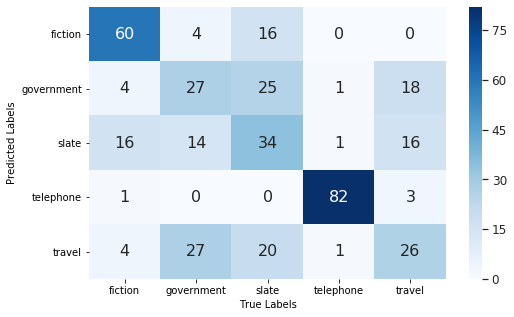

In [14]:
generate_confusion_matrix(labels_test,preds,label_encoder.classes_)

## References

1. Yang, Zhilin, Zihang Dai, Yiming Yang, Jaime Carbonell, Ruslan Salakhutdinov, and Quoc V. Le. [*XLNet: Generalized Autoregressive Pretraining for Language Understanding.*](https://arxiv.org/abs/1906.08237), 2019.
2. Devlin, Jacob and Chang, Ming-Wei and Lee, Kenton and Toutanova, Kristina, [*BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding*](https://arxiv.org/abs/1810.04805), ACL, 2018.
3. Dai, Zihang, Zhilin Yang, Yiming Yang, William W. Cohen, Jaime Carbonell, Quoc V. Le, and Ruslan Salakhutdinov. [*Transformer-xl: Attentive language models beyond a fixed-length context.*](https://arxiv.org/pdf/1901.02860), 2019.
4. Adina Williams, Nikita Nangia, Samuel R. Bowman. [*A Broad-Coverage Challenge Corpus for Sentence Understanding through Inference*](https://www.nyu.edu/projects/bowman/multinli/paper.pdf), 2016. Dataset available at (https://www.nyu.edu/projects/bowman/multinli/).
5. PyTorch-Transformers: a library of state-of-the-art pre-trained models for Natural Language Processing (NLP). Repository available at (https://github.com/huggingface/pytorch-transformers).